# Calculate the variance of an asset 

In this example we will calculate the variance of an asset using ezkl. Here's a diagram of the process:

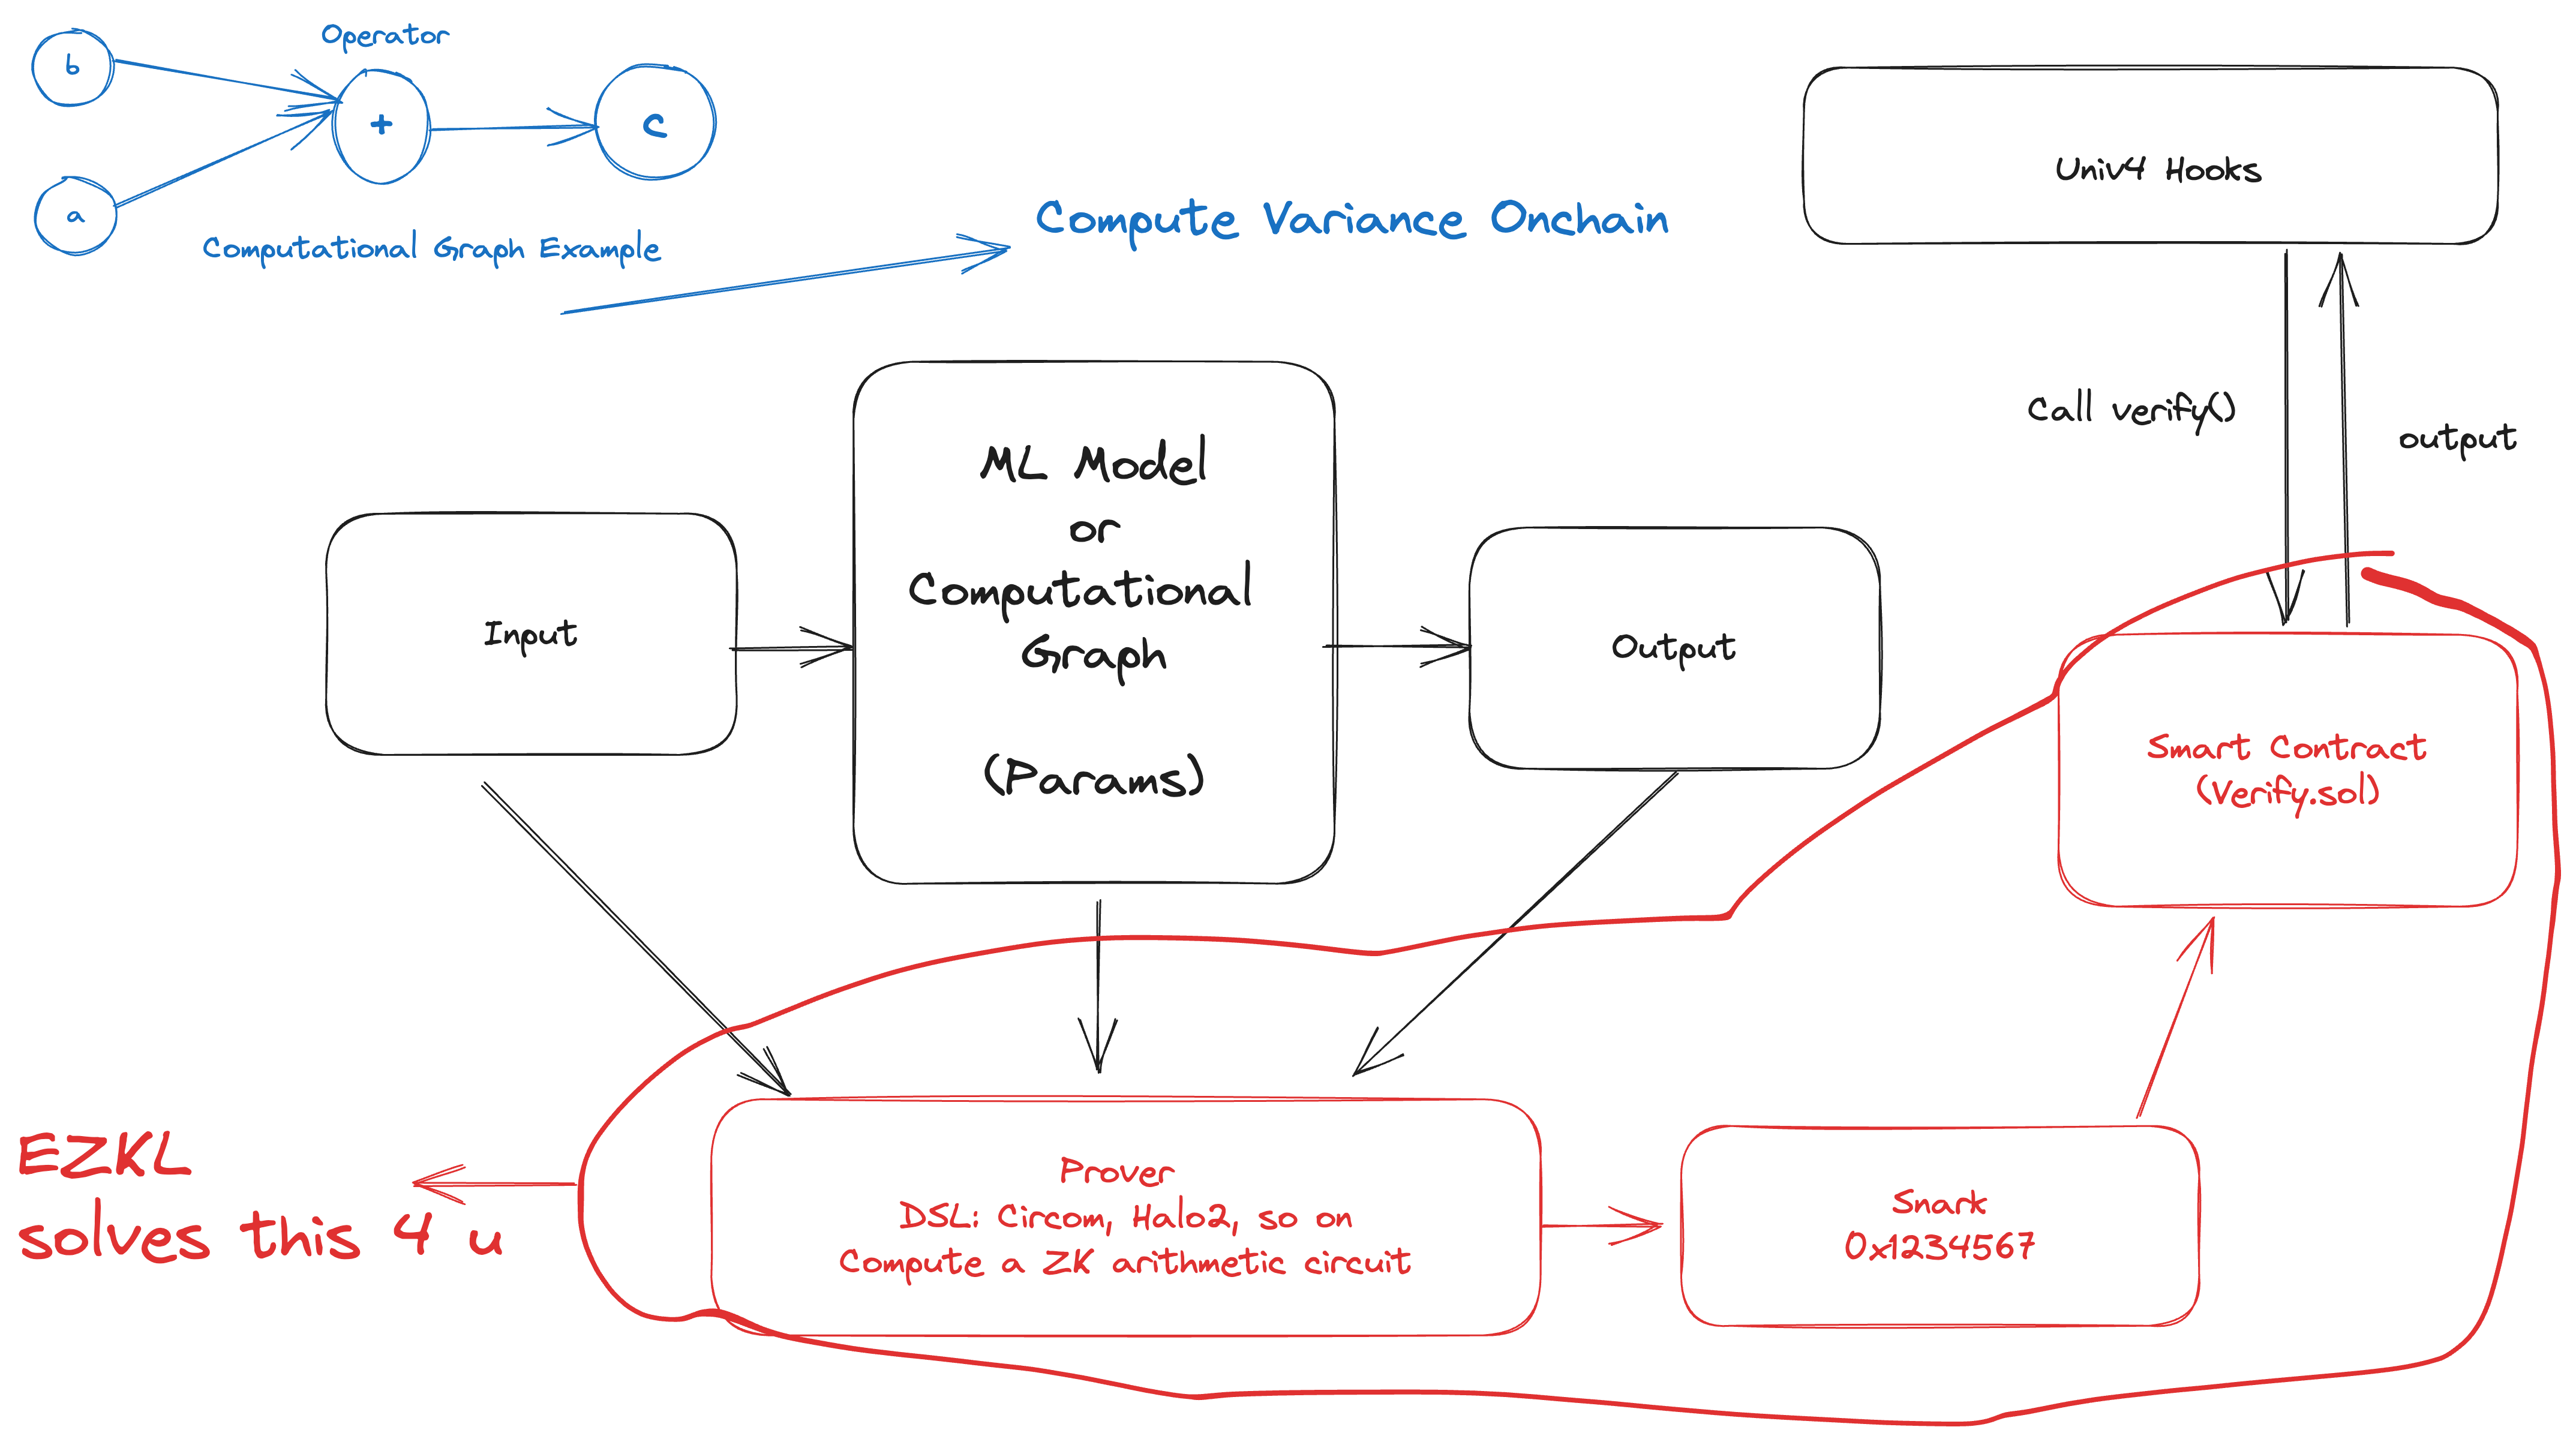

**Import Dependencies**

In [ ]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import torch
import datetime
import pandas as pd
import requests
import json
import os

**Create Computational Graph**

In [ ]:
from torch import nn
import torch


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    # x is a time series maybe the ETH/USDC price, that we get from Uni Oracle
    def forward(self, x):
        # return [torch.var(x, unbiased=False, dim=[1,2])]
        return [torch.mean(x)]




circuit = Model()




x = 0.1*torch.rand(1,*[1,20], requires_grad=True)

# # print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

circuit.to(device)

# Flips the neural net into inference mode
circuit.eval()

# Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      "lol.onnx",            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=11,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

# export(circuit, input_shape=[1, 20])



**Set Data Source and Get Data**

In [ ]:

def get_url(coin, currency, start, end):
  url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range?vs_currency={currency}&from={start}&to={end}"
  return url


timenow = datetime.datetime.now()
timenow_unix_sec = int(datetime.datetime.timestamp(timenow))
time7days = timenow - datetime.timedelta(days=7)
time7days_unix_sec = int(datetime.datetime.timestamp(time7days))

print(timenow_unix_sec)
print(time7days_unix_sec)

eth_price_url = get_url("ethereum", "usd", time7days_unix_sec, timenow_unix_sec)
print(eth_price_url)

data = requests.get(eth_price_url)
print(data)

new_data = {"time": [], "prices": []}

for k, v in data.json().items():
  if k == "prices":
    for x in v:
      new_data["time"].append(x[0])
      new_data["prices"].append(x[1])


In [ ]:
df = pd.DataFrame(new_data)
df


**EZKL Workflow**

In [ ]:
# setup kzg params
params_path = os.path.join('kzg.params')
res = ezkl.gen_srs(params_path, 7)

In [ ]:
# make an input.json file from the df above
input_filename = os.path.join('input.json')
# get the last 20 prices and make a list
df_prices = df['prices'].tail(20).tolist()

data = dict(input_data = [df_prices])

    # Serialize data into file:
json.dump( data, open(input_filename, 'w' ))

In [ ]:
# generate settings
onnx_filename = os.path.join('lol.onnx')
compiled_filename = os.path.join('lol.compiled')
settings_filename = os.path.join('settings.json')



ezkl.gen_settings(onnx_filename, settings_filename)
ezkl.calibrate_settings(
    input_filename, onnx_filename, settings_filename, "resources")
ezkl.compile_model(onnx_filename, compiled_filename, settings_filename)

# show the settings.json
with open("settings.json") as f:
  data = json.load(f)
  json_formatted_str = json.dumps(data, indent=2)

  print(json_formatted_str)
  
assert os.path.exists("settings.json")
assert os.path.exists("input.json")
assert os.path.exists("lol.onnx")

In [ ]:
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
params_path = os.path.join('kzg.params')


# setup the proof
res = ezkl.setup(
        compiled_filename,
        vk_path,
        pk_path,
        params_path,
        settings_filename,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_filename)



In [ ]:

witness_path = "witness.json"

res = ezkl.gen_witness(input_filename, compiled_filename, witness_path, settings_path = settings_filename)
assert os.path.isfile(witness_path)

In [ ]:
# prove the zk circuit
# GENERATE A PROOF
proof_path = os.path.join('test.pf')


proof = ezkl.prove(
        witness_path,
        compiled_filename,
        pk_path,
        proof_path,
        params_path,
        "evm",
        "single",
        settings_filename,
    )


assert os.path.isfile(proof_path)

# verify
res = ezkl.verify(
        proof_path,
        settings_filename,
        vk_path,
        params_path,
    )

assert res == True
print("verified")

# Part 2 (Using the ZK Computational Graph Onchain!)

**Now How Do We Do It Onchain?????**

In [ ]:
# first we need to create evm verifier
print(vk_path)
print(params_path)
print(settings_filename)


abi_path = 'test.abi'
sol_code_path = 'test.sol'

res = ezkl.create_evm_verifier(
        vk_path,
        params_path,
        settings_filename,
        sol_code_path,
        abi_path,
    )
assert res == True

In [ ]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

In [ ]:
# read the address from addr_path
addr = None
with open(address_path, 'r') as f:
    addr = f.read()

res = ezkl.verify_evm(
    proof_path,
    addr,
    "http://127.0.0.1:3030"
)
assert res == True